# Clustering of cleaned USPTO using NameRxn from Nextmove software

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
# import train_test_split
from sklearn.model_selection import train_test_split

In [6]:
# Create a function to read in the data

def read_data(smi_path, parquet_path):
    """
    smi_path: e.g. "../data/raw/orderly_cond_classes.smi"
    parquet_path: e.g. "../data/raw/orderly_condition_train.parquet"
    """
    # read in rxn class data:
    with open(smi_path, "r") as file:
        lines = file.readlines()

    # Split each line and create a list of lists
    data = [line.strip().split(" ") for line in lines]

    # Create a dataframe
    df = pd.DataFrame(data, columns=['Reaction_String', 'Reaction_Class'])

    # Read in reaction conditions data
    df2 = pd.read_parquet(parquet_path)

    # Merge the two dataframes
    df[['product_000', 'reactant_000', 'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001', 'agent_002']] = df2[['product_000', 'reactant_000', 'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001', 'agent_002']]

    df['Reaction_Class'] = df['Reaction_Class'].replace('0.0', '0.0.0')

    # Split the 'Reaction_Class' column
    df['super class'] = df['Reaction_Class'].str.split('.').str[0]
    df['mid class'] = df['Reaction_Class'].str.split('.').str[0] + '.' + df['Reaction_Class'].str.split('.').str[1]

    return df

super_class_dict = {
    "0": "Unassigned",
    "1": "Heteroatom alkylation and arylation",
    "2": "Acylation and related processes",
    "3": "C-C bond formation",
    "4": "Heterocycle formation",
    "5": "Protections",
    "6": "Deprotections",
    "7": "Reductions",
    "8": "Oxidations",
    "9": "Functional group interconversion (FGI)",
    "10": "Functional group addition (FGA)",
    "11": "Resolution",
    "12": "Miscellaneous"
}

mid_class_dict = {
    "0": "Unassigned",
    "0.1": "Failed reaction",
    "0.2": "Compound purchase",
    "1": "Heteroatom alkylation and arylation",
    "1.1": "N-substitution with alkyl-X",
    "1.2": "Reductive amination",
    "1.3": "N-arylation with Ar-X",
    "1.4": "Amide N-alkylation",
    "1.5": "Aniline N-alkylation",
    "1.6": "Heteroaryl N-alkylation",
    "1.7": "O-substitution",
    "1.8": "S-substitution",
    "1.9": "Other heteroatom alkylation/arylation",
    "2": "Acylation and related processes",
    "2.1": "N-acylation to amide",
    "2.2": "N-sulfonylation",
    "2.3": "N-acylation to urea",
    "2.4": "Carbamate/carbonate formation",
    "2.5": "Amidine formation",
    "2.6": "O-acylation to ester",
    "2.7": "O-sulfonylation",
    "2.8": "Other acylation",
    "3": "C-C bond formation",
    "3.1": "Suzuki coupling",
    "3.2": "Heck reaction",
    "3.3": "Sonogashira reaction",
    "3.4": "Stille reaction",
    # "3.5": "Other Pd-catalyzed reactions (Negishi, Kumada, etc.)",
    "3.5": "Other Pd-catalyzed reaction",
    "3.6": "Ester condensation",
    "3.7": "Grignard",
    "3.8": "Wittig olefination",
    # "3.9": "Other organometallic C-C bond formation",
    "3.9": "Other organometallic reaction",
    "3.10": "Friedel-Crafts acylation",
    "3.11": "Other C-C bond formation",
    "4": "Heterocycle formation",
    "4.1": "N-containing heterocycle formation",
    "4.2": "O-containing heterocycle formation",
    "4.3": "S-containing heterocycle formation",
    "4.4": "Other heterocycle forming reactions",
    "5": "Protections",
    "5.1": "NH protections",
    "5.2": "RCO2H protections",
    "5.3": "ROH protections",
    "5.4": "RSH protections",
    "5.5": "Other protections",
    "6": "Deprotections",
    "6.1": "NH deprotections",
    "6.2": "RCO2H deprotections",
    "6.3": "ROH deprotections",
    "6.4": "RSH deprotections",
    "6.5": "Other deprotections",
    "7": "Reductions",
    "7.1": "Nitro to amine reduction",
    "7.2": "Amide to amine reduction",
    "7.3": "Cyano or imine to amine",
    "7.4": "Ester to alcohol",
    "7.5": "Ketone to alcohol",
    "7.6": "Alkene to alkane",
    "7.7": "Alkyne to alkane",
    "7.8": "Aryl/hetaryl to fully saturated",
    "7.9": "Other reductions",
    "8": "Oxidations",
    "8.1": "Alcohols to aldehydes",
    "8.2": "Oxidations at sulphur",
    "8.3": "Alcohols to acids",
    "8.4": "Oxidations at nitrogen",
    "8.5": "Alkene oxidative cleavage",
    "8.6": "Benzylic/allylic oxidation",
    "8.7": "Alkene oxidation",
    "8.8": "Other oxidations",
    "9": "Functional group interconversion (FGI)",
    "9.1": "Alcohol to halide",
    "9.2": "Amide to imidoyl chloride",
    "9.3": "Acid to acid chloride",
    "9.4": "Nitrile to acid",
    "9.5": "Dehydration",
    "9.6": "Carbonyl to C=N",
    "9.7": "Other functional group interconversion",
    "10": "Functional group addition (FGA)",
    "10.1": "Halogenation",
    "10.2": "Nitration",
    "10.3": "Sulfonation",
    "10.4": "Other functional group addition",
    "11": "Resolution",
    "11.1": "Purification",
    "11.2": "Separation",
    "11.3": "Chiral separation",
    "11.4": "Ion exchange",
    "11.5": "Isomerization",
    "11.6": "Purification",
    "11.7": "Racemization",
    "11.8": "Salt formation",
    "11.9": "Separation",
    "12": "Miscellaneous",
    "12.1": "Diazald diazomethane preparation",
    "12.2": "MNNG diazomethane preparation"
}
# make value more readable by adding the rxn class number
super_class_dict = {key: f"{key}. {value}" for key, value in super_class_dict.items()}
mid_class_dict = {key: f"{key} {value}" for key, value in mid_class_dict.items()}

In [7]:
len(super_class_dict), len(mid_class_dict), 

(13, 96)

In [8]:
parent = '/Users/danielwigh/projects_local/parameter sharing project/data/v6/'

df = read_data(parent+"orderly_condition_train_classified.smi", parent+"orderly_no_trust_no_min_freq_train.parquet")
df['super class name'] = df['super class'].map(super_class_dict)
df['mid class name'] = df['mid class'].map(mid_class_dict)
len(set(df['super class'])), len(set(df['mid class'])), len(set(df['Reaction_Class']))

(12, 74, 6080)

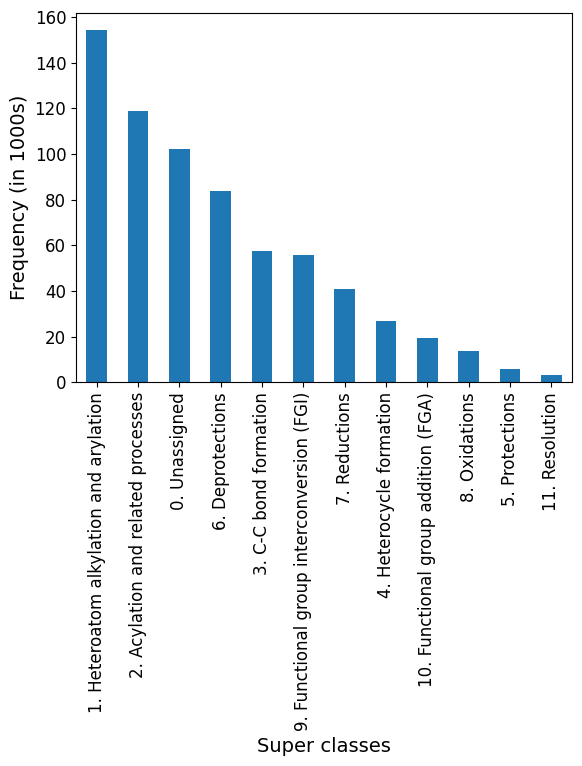

In [12]:
# Plot histogram
df['super class name'].value_counts().plot(kind='bar')

# Updating the title and label sizes
# plt.title('Distribution of super class', fontsize=18)
plt.xlabel('Super classes', fontsize=14)
plt.ylabel('Frequency (in 1000s)', fontsize=14)

# Formatting the y-tick labels to represent values in thousands
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,.0f}'.format(x/1000)))

# Setting the font size of the ticks
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# save
plt.savefig('../figures/orderly_cond_v6_with_ag_super_classes.png', dpi=600, bbox_inches='tight')
plt.show()

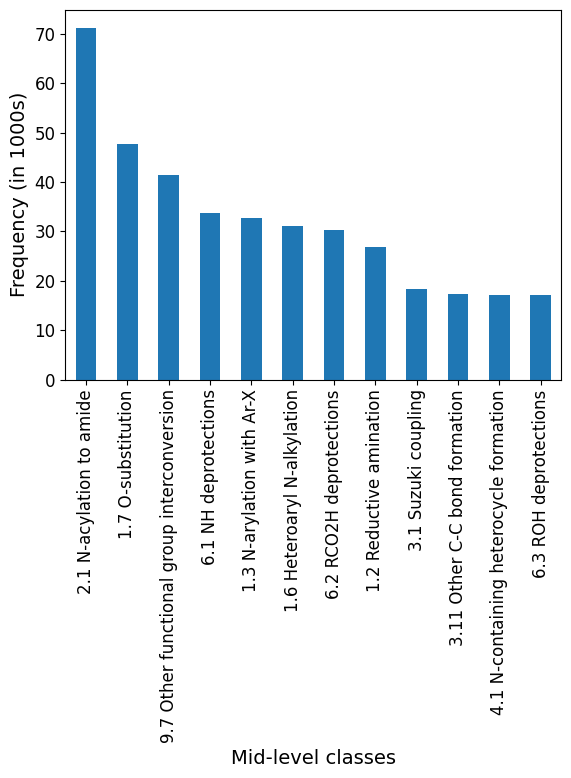

In [13]:
# Plot histogram
df['mid class name'].value_counts()[:12].plot(kind='bar')

# Updating the title and label sizes
# plt.title('Distribution of mid class', fontsize=18)
plt.xlabel('Mid-level classes', fontsize=14)
plt.ylabel('Frequency (in 1000s)', fontsize=14)

# Formatting the y-tick labels to represent values in thousands
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,.0f}'.format(x/1000)))

# Setting the font size of the ticks
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.savefig('../figures/orderly_cond_v6_with_ag_super_classes.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

## Build train test splits based on rxn class

In [14]:
# Remove unassigned reactions
print(len(df))
df = df[df['super class'] != '0']
print(len(df))

682576
580570


In [14]:
# I don't want to train models with super class split
# super_class_train = df[df['super class'] != '3']
# super_class_test = df[df['super class'] == '3']
# # save as parquet
# super_class_train.to_parquet('../data/super_class_cc_train.parquet')
# super_class_test.to_parquet('../data/super_class_cc_test.parquet')

# super_class_fgi_train = df[df['super class'] != '9']
# super_class_fgi_test = df[df['super class'] == '9']
# # save as parquet
# super_class_fgi_train.to_parquet('../data/super_class_fgi_train.parquet')
# super_class_fgi_test.to_parquet('../data/super_class_fgi_test.parquet')

# super_class_reductions_train = df[df['super class'] != '7']
# super_class_reductions_test = df[df['super class'] == '7']
# # save as parquet
# super_class_reductions_train.to_parquet('../data/super_class_reductions_train.parquet')
# super_class_reductions_test.to_parquet('../data/super_class_reductions_test.parquet')



In [16]:
# For subclass split, randomly select one of the mid classes from each super class
# I used google rng to select a random subclass from each
# 1.5
# 2.4
# 3.8
# 4.2
# 5.4
# 6.1
# 7.5
# 8.1
# 9.3
# 10.2
# 11.4
# 12.1
# List of values to filter
values_to_exclude = ['1.5', '2.4', '3.8', '4.2', '5.4', '6.1', '7.5', '8.1', '9.3', '10.2', '11.4', '12.1']

# Create train and test dataframes
mid_class_train = df[~df['mid class'].isin(values_to_exclude)]
mid_class_test = df[df['mid class'].isin(values_to_exclude)]
# save as parquet
mid_class_train.to_parquet('../data/mid_class_train.parquet')
mid_class_test.to_parquet('../data/mid_class_test.parquet')

In [17]:
len(super_class_train), len(super_class_test), len(mid_class_train), len(mid_class_test)

(278240, 28187, 271394, 35033)

In [18]:
(35033)/(35033+271394)

0.11432739282112869

# Add OHE columns to FP data

In [2]:
random_train = pd.read_parquet('../data/random_train.parquet')
random_test = pd.read_parquet('../data/random_test.parquet')

random_train_fp = np.load('../data/fingerprints/random_train.npy')
random_test_fp = np.load('../data/fingerprints/random_test.npy')

In [3]:
# create OHE based on super class
enc = OneHotEncoder(handle_unknown='ignore')
# fit on train data
enc.fit(random_train[['super class']])
# transform train and test data
random_train_ohe = enc.transform(random_train[['super class']])
random_test_ohe = enc.transform(random_test[['super class']])
# convert to array
random_train_ohe = random_train_ohe.toarray()
random_test_ohe = random_test_ohe.toarray()

# add to the random_train_fp and random_test_fp
random_train_fp = np.concatenate((random_train_fp, random_train_ohe), axis=1)
random_test_fp = np.concatenate((random_test_fp, random_test_ohe), axis=1)

# Add a column of zeroes so it's an even number
random_train_fp = np.concatenate((random_train_fp, np.zeros((len(random_train_fp), 1))), axis=1)
random_test_fp = np.concatenate((random_test_fp, np.zeros((len(random_test_fp), 1))), axis=1)

In [5]:
# save as npy
np.save('../data/fingerprints/random_train_fp_ohe.npy', random_train_fp)
np.save('../data/fingerprints/random_test_fp_ohe.npy', random_test_fp)

In [6]:
random_train_fp.shape

(245141, 4108)

# Inspect most popular reaction condition combinations

In [15]:
# just run the first section of the nb to get the right df, which contains all data and also the super class
df.columns

Index(['Reaction_String', 'Reaction_Class', 'product_000', 'reactant_000',
       'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001',
       'agent_002', 'super class', 'mid class', 'super class name',
       'mid class name'],
      dtype='object')

In [16]:
df.shape

(580570, 14)

In [18]:
def get_top_n(df, n):
    # Sort elements in each row and get the top n most frequent rows
    sorted_rows = [tuple(sorted(row, key=lambda x: (x is None, x))) for row in df.values]
    row_counts = Counter(sorted_rows)
    num_data = len(df)
    most_common = row_counts.most_common(n) 
    data_dict = {}
    names = []
    percent = []
    for i, (row, count) in enumerate(most_common):
        try:
            a,b = row
            names += [f"{a} + {b}" if b is not None else a]
        except ValueError:
            a,b,c = row
            if c is None:
                if b is None:
                    names += [a]
                else:
                    names += [f"{a} + {b}"]
            else:
                names += [f"{a} + {b} + {c}"]
            
        percent += [count / num_data]
        
    # create dict mapping name to percent
    data_dict = dict(zip(names, percent))
    return names, percent, data_dict

# [f"{a}+{b}" if b is not None else a for a, b in row]
# Get the top 10 most frequent rows



In [19]:
top_10_overall = get_top_n(df[['solvent_000', 'solvent_001']], 10)
x_overall, y_overall, dict_overall = top_10_overall

In [25]:
y_results = []
# do it all
for rxn_class in range(1,13):
    # only 1 rxn class at a time
    df_class = df[df['super class'] == str(rxn_class)]
    
    # Get the top 10 most frequent rows
    # x is the names, y is the percent, dict is the mapping
    top_10_class = get_top_n(df_class[['solvent_000', 'solvent_001']], 10)
    x_class, y_class, dict_class = top_10_class

    # Find percentages for the top 10 most frequent solvents overall
    y_f = []
    for i in x_overall:
        try:
            y_f += [dict_class[i]]
        except KeyError:
            y_f += [0]
    y_results += [y_f]



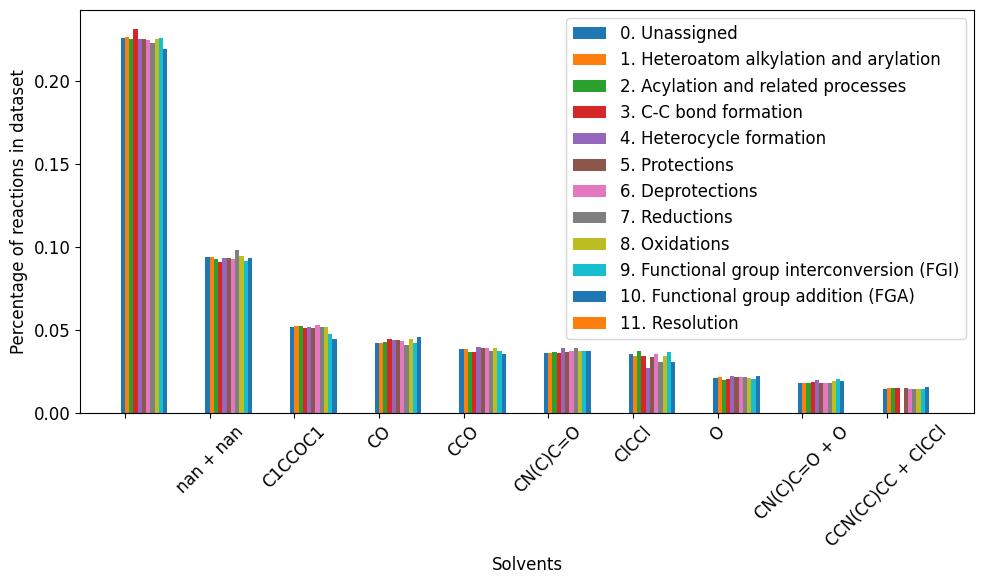

In [40]:
# plot
rxn_classes = list(super_class_dict.values())
plt.figure(figsize=(10, 6))
bar_width = 0.05
index = range(len(x_overall))
for i, y in enumerate(y_results):
    plt.bar([x + i * bar_width for x in index], y, bar_width, label=rxn_classes[i])  # Adjust index for each bar

#Change font size to 14
plt.rcParams.update({'font.size': 12})

# Add title and labels
plt.xlabel('Solvents')
plt.ylabel('Percentage of reactions in dataset')
# plt.title('Comparative Bar Chart')
plt.xticks([i + bar_width / 2 for i in index], x_overall, rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('../figures/orderly-cond-v6-solvent-dist.png', dpi=600, bbox_inches='tight')
plt.show()

In [42]:
df_cc = df[df['super class'] == '3']
print(len(df_cc))
# which percentage of reactions have C1CCOC1 as solvent_000
len(df_cc[df_cc['solvent_000'] == 'C1CCOC1'])/len(df_cc)

57702


0.07831617621572909

In [43]:
df_1 = df[df['super class'] == '1']
print(len(df_1))
# which percentage of reactions have C1CCOC1 as solvent_000
len(df_1[df_1['solvent_000'] == 'C1CCOC1'])/len(df_1)

154138


0.0774435895106982

# Repeat analysis, but for agents

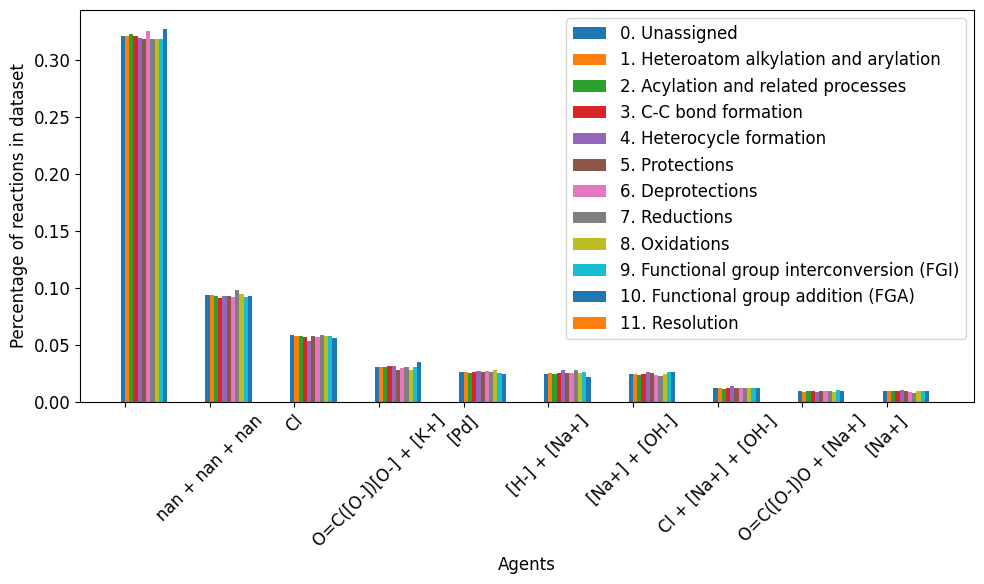

In [45]:
columns = ['agent_000', 'agent_001', 'agent_002']
top_10_overall = get_top_n(df[columns], 10)
x_overall, y_overall, dict_overall = top_10_overall

y_results = []
# do it all
for rxn_class in range(1,13):
    # only 1 rxn class at a time
    df_class = df[df['super class'] == str(rxn_class)]
    
    # Get the top 10 most frequent rows
    # x is the names, y is the percent, dict is the mapping
    top_10_class = get_top_n(df_class[columns], 10)
    x_class, y_class, dict_class = top_10_class

    # Find percentages for the top 10 most frequent solvents overall
    y_f = []
    for i in x_overall:
        try:
            y_f += [dict_class[i]]
        except KeyError:
            y_f += [0]
    y_results += [y_f]

# plot
rxn_classes = list(super_class_dict.values())
plt.figure(figsize=(10, 6))
bar_width = 0.05
index = range(len(x_overall))
for i, y in enumerate(y_results):
    plt.bar([x + i * bar_width for x in index], y, bar_width, label=rxn_classes[i])  # Adjust index for each bar

#Change font size to 14
plt.rcParams.update({'font.size': 12})

# Add title and labels
plt.xlabel('Agents')
plt.ylabel('Percentage of reactions in dataset')
# plt.title('Comparative Bar Chart')
plt.xticks([i + bar_width / 2 for i in index], x_overall, rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('../figures/orderly-cond-v6-agents-dist.png', dpi=600, bbox_inches='tight')
plt.show()

# pistachio

In [58]:
import os
from tqdm import tqdm

In [61]:
folder_path = '/Users/dsw46/Library/CloudStorage/OneDrive-UniversityofCambridge/Datasets/processed_data_pistachio/subset/'
# walk through all files in the folder
dfs = []
for filename in tqdm(os.listdir(folder_path)):
    if '.DS_Store' in filename:
        continue
    path = folder_path + filename
    df = pd.read_pickle(path)
    dfs.append(df)

# Concatenate all dataframes
df_pistachio = pd.concat(dfs)

100%|██████████| 233/233 [02:18<00:00,  1.68it/s]


In [104]:
def get_top_n(series, n):
    num_data = len(series)
    series = series.dropna()
    # Sort elements in each row and get the top n most frequent rows
    sorted_rows = [tuple(sorted(row, key=lambda x: (x is None, x))) for row in series.values]
    
    row_counts = Counter(sorted_rows)
    most_common = row_counts.most_common(n) 
    data_dict = {}
    names = []
    percent = []
    for i, (row, count) in enumerate(most_common):
        percent += [count / num_data]
        if len(row) == 0:
            names += ['None']
        elif len(row) == 1:
            names += [row[0]]
        elif len(row) == 2:
            a,b = row
            names += [f"{a} + {b}" if b is not None else a]
        elif len(row) == 3:
            a,b,c = row
            names += [f"{a} + {b} + {c}"]
        
        
    # create dict mapping name to percent
    data_dict = dict(zip(names, percent))
    return names, percent, data_dict

# [f"{a}+{b}" if b is not None else a for a, b in row]
# Get the top 10 most frequent rows



In [105]:
df = df_pistachio.copy()
top_10_overall = get_top_n(df['solvent_smiles'], 10)
x_overall, y_overall, dict_overall = top_10_overall

In [106]:
df['super class'] = df['namerxn_pistachio'].str.split('.').str[0]

In [107]:
df1 = df[df['super class'] == '1']
df2 = df[df['super class'] == '2']
df3 = df[df['super class'] == '3']
df4 = df[df['super class'] == '4']
df5 = df[df['super class'] == '5']
df6 = df[df['super class'] == '6']
df7 = df[df['super class'] == '7']
df8 = df[df['super class'] == '8']
df9 = df[df['super class'] == '9']
df10 = df[df['super class'] == '10']
df11 = df[df['super class'] == '11']
df12 = df[df['super class'] == '12']

In [108]:
len(df)

1282845

In [109]:
x1,y1,d1 = get_top_n(df1['solvent_smiles'], 100)
x2,y2,d2 = get_top_n(df2['solvent_smiles'], 100)
x3,y3,d3 = get_top_n(df3['solvent_smiles'], 100)
x4,y4,d4 = get_top_n(df4['solvent_smiles'], 100)
x5,y5,d5 = get_top_n(df5['solvent_smiles'], 100)
x6,y6,d6 = get_top_n(df6['solvent_smiles'], 100)
x7,y7,d7 = get_top_n(df7['solvent_smiles'], 100)
x8,y8,d8 = get_top_n(df8['solvent_smiles'], 100)
x9,y9,d9 = get_top_n(df9['solvent_smiles'], 100)
x10,y10,d10 = get_top_n(df10['solvent_smiles'], 100)
x11,y11,d11 = get_top_n(df11['solvent_smiles'], 100)
x12,y12,d12 = get_top_n(df12['solvent_smiles'], 100) 


In [110]:
y_1_f = []
for i in x_overall:
    try:
        y_1_f += [d1[i]]
    except KeyError:
        y_1_f += [0]

y_2_f = []
for i in x_overall:
    try:
        y_2_f += [d2[i]]
    except KeyError:
        y_2_f += [0]
        
y_3_f = []
for i in x_overall:
    try:
        y_3_f += [d3[i]]
    except KeyError:
        y_3_f += [0]
        
y_4_f = []
for i in x_overall:
    try:
        y_4_f += [d4[i]]
    except KeyError:
        y_4_f += [0]

y_5_f = []
for i in x_overall:
    try:
        y_5_f += [d5[i]]
    except KeyError:
        y_5_f += [0]
        
y_6_f = []
for i in x_overall:
    try:
        y_6_f += [d6[i]]
    except KeyError:
        y_6_f += [0]

y_7_f = []
for i in x_overall:
    try:
        y_7_f += [d7[i]]
    except KeyError:
        y_7_f += [0]

y_8_f = []
for i in x_overall:
    try:
        y_8_f += [d8[i]]
    except KeyError:
        y_8_f += [0]

y_9_f = []
for i in x_overall:
    try:
        y_9_f += [d9[i]]
    except KeyError:
        y_9_f += [0]

y_10_f = []
for i in x_overall:
    try:
        y_10_f += [d10[i]]
    except KeyError:
        y_10_f += [0]

y_11_f = []
for i in x_overall:
    try:
        y_11_f += [d11[i]]
    except KeyError:
        y_11_f += [0]

y_12_f = []
for i in x_overall:
    try:
        y_12_f += [d12[i]]
    except KeyError:
        y_12_f += [0]

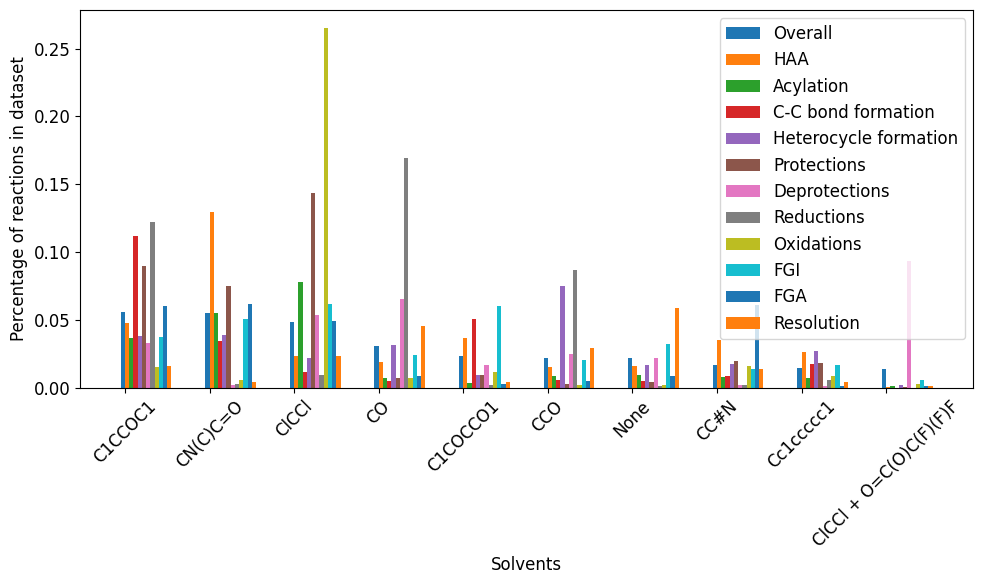

In [111]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.05
index = range(len(x_overall))

# Create bars
plt.bar(index, y_overall, width=bar_width, label='Overall')
plt.bar([i + bar_width for i in index], y_1_f, width=bar_width, label='HAA')
plt.bar([i + bar_width*2 for i in index], y_2_f, width=bar_width, label='Acylation')
plt.bar([i + bar_width*3 for i in index], y_3_f, width=bar_width, label='C-C bond formation')
plt.bar([i + bar_width*4 for i in index], y_4_f, width=bar_width, label='Heterocycle formation')
plt.bar([i + bar_width*5 for i in index], y_5_f, width=bar_width, label='Protections')
plt.bar([i + bar_width*6 for i in index], y_6_f, width=bar_width, label='Deprotections')
plt.bar([i + bar_width*7 for i in index], y_7_f, width=bar_width, label='Reductions')
plt.bar([i + bar_width*8 for i in index], y_8_f, width=bar_width, label='Oxidations')
plt.bar([i + bar_width*9 for i in index], y_9_f, width=bar_width, label='FGI')
plt.bar([i + bar_width*10 for i in index], y_10_f, width=bar_width, label='FGA')
plt.bar([i + bar_width*11 for i in index], y_11_f, width=bar_width, label='Resolution')
# plt.bar([i + bar_width*12 for i in index], y_12_f, width=bar_width, label='Super class 12')

#Change font size to 14
plt.rcParams.update({'font.size': 12})

# Add title and labels
plt.xlabel('Solvents')
plt.ylabel('Percentage of reactions in dataset')
# plt.title('Comparative Bar Chart')
plt.xticks([i + bar_width / 2 for i in index], x_overall, rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('pistachio_solvents_super_class_dist.png', dpi=600, bbox_inches='tight')
plt.show()

In [112]:
# pistachio agents: agent_smiles
top_10_overall = get_top_n(df['agent_smiles'], 10)
x_overall, y_overall, dict_overall = top_10_overall

In [113]:
x1,y1,d1 = get_top_n(df1['agent_smiles'], 100)
x2,y2,d2 = get_top_n(df2['agent_smiles'], 100)
x3,y3,d3 = get_top_n(df3['agent_smiles'], 100)
x4,y4,d4 = get_top_n(df4['agent_smiles'], 100)
x5,y5,d5 = get_top_n(df5['agent_smiles'], 100)
x6,y6,d6 = get_top_n(df6['agent_smiles'], 100)
x7,y7,d7 = get_top_n(df7['agent_smiles'], 100)
x8,y8,d8 = get_top_n(df8['agent_smiles'], 100)
x9,y9,d9 = get_top_n(df9['agent_smiles'], 100)
x10,y10,d10 = get_top_n(df10['agent_smiles'], 100)
x11,y11,d11 = get_top_n(df11['agent_smiles'], 100)
x12,y12,d12 = get_top_n(df12['agent_smiles'], 100) 


In [114]:
y_1_f = []
for i in x_overall:
    try:
        y_1_f += [d1[i]]
    except KeyError:
        y_1_f += [0]

y_2_f = []
for i in x_overall:
    try:
        y_2_f += [d2[i]]
    except KeyError:
        y_2_f += [0]
        
y_3_f = []
for i in x_overall:
    try:
        y_3_f += [d3[i]]
    except KeyError:
        y_3_f += [0]
        
y_4_f = []
for i in x_overall:
    try:
        y_4_f += [d4[i]]
    except KeyError:
        y_4_f += [0]

y_5_f = []
for i in x_overall:
    try:
        y_5_f += [d5[i]]
    except KeyError:
        y_5_f += [0]
        
y_6_f = []
for i in x_overall:
    try:
        y_6_f += [d6[i]]
    except KeyError:
        y_6_f += [0]

y_7_f = []
for i in x_overall:
    try:
        y_7_f += [d7[i]]
    except KeyError:
        y_7_f += [0]

y_8_f = []
for i in x_overall:
    try:
        y_8_f += [d8[i]]
    except KeyError:
        y_8_f += [0]

y_9_f = []
for i in x_overall:
    try:
        y_9_f += [d9[i]]
    except KeyError:
        y_9_f += [0]

y_10_f = []
for i in x_overall:
    try:
        y_10_f += [d10[i]]
    except KeyError:
        y_10_f += [0]

y_11_f = []
for i in x_overall:
    try:
        y_11_f += [d11[i]]
    except KeyError:
        y_11_f += [0]

y_12_f = []
for i in x_overall:
    try:
        y_12_f += [d12[i]]
    except KeyError:
        y_12_f += [0]

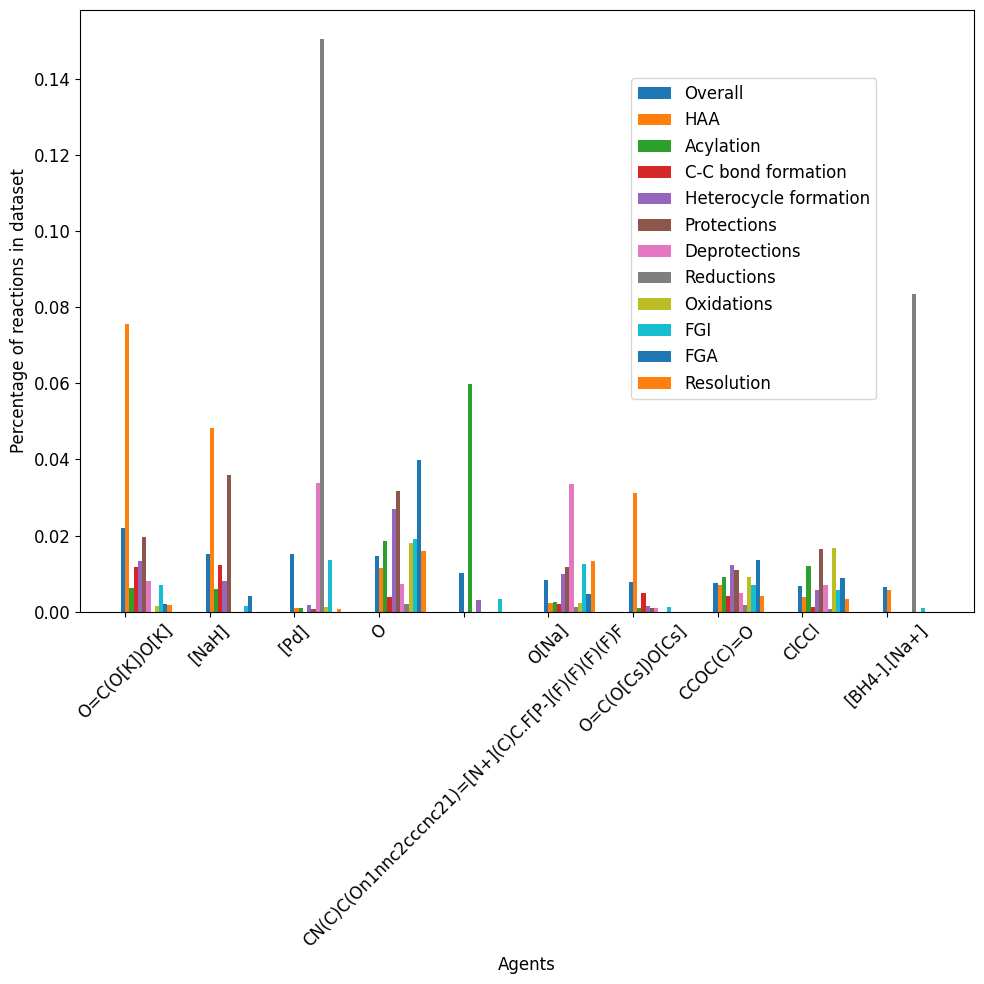

In [115]:
# Plotting
plt.figure(figsize=(10, 10))
bar_width = 0.05
index = range(len(x_overall))

# Create bars
plt.bar(index, y_overall, width=bar_width, label='Overall')
plt.bar([i + bar_width for i in index], y_1_f, width=bar_width, label='HAA')
plt.bar([i + bar_width*2 for i in index], y_2_f, width=bar_width, label='Acylation')
plt.bar([i + bar_width*3 for i in index], y_3_f, width=bar_width, label='C-C bond formation')
plt.bar([i + bar_width*4 for i in index], y_4_f, width=bar_width, label='Heterocycle formation')
plt.bar([i + bar_width*5 for i in index], y_5_f, width=bar_width, label='Protections')
plt.bar([i + bar_width*6 for i in index], y_6_f, width=bar_width, label='Deprotections')
plt.bar([i + bar_width*7 for i in index], y_7_f, width=bar_width, label='Reductions')
plt.bar([i + bar_width*8 for i in index], y_8_f, width=bar_width, label='Oxidations')
plt.bar([i + bar_width*9 for i in index], y_9_f, width=bar_width, label='FGI')
plt.bar([i + bar_width*10 for i in index], y_10_f, width=bar_width, label='FGA')
plt.bar([i + bar_width*11 for i in index], y_11_f, width=bar_width, label='Resolution')
# plt.bar([i + bar_width*12 for i in index], y_12_f, width=bar_width, label='Super class 12')

#Change font size to 14
plt.rcParams.update({'font.size': 12})

# Add title and labels
plt.xlabel('Agents')
plt.ylabel('Percentage of reactions in dataset')
# plt.title('Comparative Bar Chart')
plt.xticks([i + bar_width / 2 for i in index], x_overall, rotation=45)

# place legend on the bottom right
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))


# Show the plot
plt.tight_layout()
plt.savefig('pistachio_agents_super_class_dist.png', dpi=600, bbox_inches='tight')
plt.show()

In [117]:
mid_class_train = pd.read_parquet('../data/mid_class_train.parquet')

In [119]:
mid_class_train.columns

Index(['Reaction_String', 'Reaction_Class', 'product_000', 'reactant_000',
       'reactant_001', 'solvent_000', 'solvent_001', 'agent_000', 'agent_001',
       'agent_002', 'super class', 'mid class', 'super class name',
       'mid class name'],
      dtype='object')

In [121]:
df['product_smiles']

0                           [CCCCCCCCCCCCOS(=O)(=O)O[Na]]
1            [CCOC(=O)CN1CCN(C(=O)NCCC[Si](OC)(OC)OC)CC1]
2           [Cc1occc(=O)c1[O-].Cc1occc(=O)c1[O-].O=[V+2]]
3            [CCOC(=O)CN1CCN(C(=O)NCCC[Si](OC)(OC)OC)CC1]
4            [CCOC(=O)CN1CCN(C(=O)NCCC[Si](OC)(OC)OC)CC1]
                              ...                        
5451    [COc1cn(-c2ccc(N3CC4(CC4)OC3=O)cc2F)nc(-c2ccnn...
5452    [COc1cc(=O)c(-c2ccnn2-c2ccccc2)nn1-c1cccc(C(F)...
5453    [COc1cn(-c2ccc(N3CCOCC3)c(F)c2F)nc(-c2ccnn2-c2...
5454                                    [Cl.NC(CO)(CO)CO]
5455                        [O=S(=O)(O)CCCN1CCOCC1.O[Na]]
Name: product_smiles, Length: 1282845, dtype: object

In [116]:
# split df into train and test
train, test = train_test_split(df, test_size=0.1, random_state=42)

# save as parquet
train.to_parquet('../data/pistachio_train.parquet')
test.to_parquet('../data/pistachio_test.parquet')

NameError: name 'train_test_split' is not defined